# ANN & WORD EMBEDDINGS

## IMPORT PACKAGES & FUNCTIONS

In [ ]:
import re
import numpy as np
import pandas as pd
from nltk import WordNetLemmatizer
import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional, GRU
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import nltk 
import pickle
from pickle import load
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from nltk import download
download('wordnet')
download('omw-1.4')
download('stopwords')
import tensorflow
import gensim
import gensim.downloader as api

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


TEXT PREPROCESSING

There are two text preprocessing methods:
 
1.    **Simple text preprocessing**: simple form of pre-processing including filtering with regex, stopword removal and dimensionality reduction with lemmatisation
2.   **Complex text preprocessing**: Stricter text pre-processing. Include transformation of contractions and grammatical derivations into their full form. The changes come from observations made with Knowledge Graphs for Increment 4.



In [ ]:
# SIMPLE TEXT PREPROCESSING
def preprocessing(text):
    text = text.lower()
    text = re.sub(r'[^0-9a-z_+\-*]', ' ', text).strip()
    lemm = WordNetLemmatizer()
    title = []
    for token in text.split():
        title.append(token)
    return ' '.join(str(elem) for elem in title)

In [ ]:
# COMPLEX TEXT PREPROCESSING
contr = {
    "aren't": "are not",
    "she'd": "she had",
    "can't": "cannot",
    "shouldn't": "should not",
    "couldn't": "could not",
    "that's": "that is",
    "didn't": "did not",
    "there's": "there is",
    "don't": "do not",
    "they're": "they are",
    "doesn't": "does not",
    "they've": "they have",
    "hadn't": "had not",
    "they'll": "they will",
    "haven't": "have not",
    "they'd": "they would",
    "he's": "he is",
    "they'd": "they had",
    "he's": "he has",
    "wasn't": "was not",
    "he'll": "he will",
    "we're": "we are",
    "he'd": "he would",
    "we've": "we have",
    "here's": "here is",
    "we'll": "we will",
    "i'm": "I am",
    "we'd": "we would",
    "i've": "I have",
    "we'd": "we had",
    "i'll": "I will",
    "weren't": "were not",
    "i'd": "I would",
    "what's": "what is",
    "i'd": "I had",
    "where's": "where is",
    "isn't": "is not",
    "who's": "who is",
    "it's": "it is",
    "who'll": "who will",
    "it's": "it has",
    "won't": "will not",
    "it's": "it has",
    "wouldn't": "would not",
    "it'll": "it will",
    "you're": "you are",
    "mustn't": "must not",
    "you've": "you have",
    "she's": "she is",
    "you'll": "you will",
    "she's": "she has",
    "you'd": "you would",
    "she'll": "she will",
    "you'd": "you had",
    "she'd": "she would"
}
capitonyms = {
    "US": "the United States of America",
    "Turkey": "turkish country",
    "Fiat": "the italian automobile manufacturer",
    "Conservative": "member of the conservative party",
    "Cat": "Catherine",
    "AM": "ante Meridiem"
}
abbreviations = {
    #"&": "and",
    #"$": "dollars",
    "dr.": "doctor",
    "assoc.": "association",
    "sr.": "senior",
    "st.": "saint"
}
def expand_dict(s, dict):
    exp = re.compile('(%s)' % '|'.join(dict.keys()))
    def replace(matcher):
        return dict[matcher.group(0)]
    return exp.sub(replace, s)
def preprocessing(text):
    text_c = expand_dict(text, capitonyms)
    text = text_c.lower()
    text_co = expand_dict(text, contr)
    text_cleaned = re.sub(r'[^0-9a-z_+\-*]', ' ', text_co).strip()
    lemm = WordNetLemmatizer()
    title = []
    for token in text_cleaned.split():
        token_lemm = lemm.lemmatize(token)
        if token_lemm not in stopwords.words('english'):
             title.append(lemm.lemmatize(token))
    return ' '.join(str(elem) for elem in title)


##IMPORT DATA FROM LOCAL FILES
Files to upload:
- test_category.csv
- test_data.csv
- train_category.csv
- train_data.csv

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_category.csv to test_category.csv
Saving test_data.csv to test_data.csv
Saving train_category.csv to train_category.csv
Saving train_data.csv to train_data.csv


## MODEL EVALUATION METRICS

In [ ]:
def my_confusion_matrix(test_label, label_pred, model_name):
    labels = ['b', 'e', 'm', 't']
    conf = confusion_matrix(test_label, label_pred)
    cmd_obj = ConfusionMatrixDisplay(conf, display_labels=labels)
    cmd_obj.plot()
    cmd_obj.ax_.set(xlabel='Predicciones', ylabel='Valores reales')
    plt.title(f'Confussion matrix: {model_name}')
    plt.show()


def my_evaluation(test_label, label_pred, model_name):
    print(f"************* METRICS AVERAGE: {model_name} *************")
    print("Accuracy: ", accuracy_score(label_pred, test_label) * 100)
    print("Precision: ", precision_score(label_pred, test_label, average='macro') * 100)
    print("Recall: ", recall_score(label_pred, test_label, average='macro') * 100)
    print("f1: ", f1_score(label_pred, test_label, average='macro') * 100)
    print()
    print(f"************* METRICS BY CATEGORY {model_name} *************")
    print("Precision by cat.: ", precision_score(label_pred, test_label, average=None) * 100)
    print("Recall by cat.: ", recall_score(label_pred, test_label, average=None) * 100)
    print("f1 by cat.: ", f1_score(label_pred, test_label, average=None) * 100)
    print()

In [ ]:
train_data_df = pd.read_csv('/content/train_data.csv')
test_data_df = pd.read_csv('/content/test_data.csv')
train_label_df = pd.read_csv('/content/train_category.csv')
test_label_df = pd.read_csv('/content/test_category.csv')

In [ ]:
train_data = train_data_df['headline']
test_data = test_data_df['headline']
train_label = train_label_df['labels'] 
test_label = test_label_df['labels']

## DATA PREPARATION

In [ ]:
labels = ['t', 'e', 'b', 'm']
vocab_size = 116900
max_token = 20 
data_tokenizer = Tokenizer(num_words=vocab_size+1)
label_tokenizer = Tokenizer()
data_tokenizer.fit_on_texts(train_data)
label_tokenizer.fit_on_texts(labels)

In [ ]:
train_data_sequences = data_tokenizer.texts_to_sequences(train_data)
test_data_sequences = data_tokenizer.texts_to_sequences(test_data)
train_label_sequences = label_tokenizer.texts_to_sequences(train_label)
test_label_sequences = label_tokenizer.texts_to_sequences(test_label)

In [ ]:
train_data_pad = pad_sequences(train_data_sequences, maxlen=max_token, padding='pre', truncating='pre')
test_data_pad = pad_sequences(test_data_sequences, maxlen=max_token, padding='pre', truncating='pre')
train_label_pad = np.array(train_label_sequences)
test_label_pad = np.array(test_label_sequences)

## WORD EMBEDDING IMPORT
- word2vec: imported from Gensim
- glove: local file 'glove.6B.300d.txt'

In [ ]:
w2v_model = api.load('word2vec-google-news-300')

[=================================================-] 99.6% 1656.6/1662.8MB downloaded


In [ ]:
from google.colab import files
uploaded = files.upload()
gloVe_path = '/content/glove.6B.300d.txt'

Saving glove.6B.300d.txt to glove.6B.300d.txt


In [ ]:
# Setting variables for the model
embed_dim = 300
max_len=20
vocab_size= len(data_tokenizer.word_index) + 1

In [ ]:
# word2vec ---> VOCAB MATRIX
def word_emb_w2v(w2v_model=w2v_model):
  vocab = w2v_model.vocab
  word_vec_dict={}
  for word in vocab:
    word_vec_dict[word] = w2v_model.wv.get_vector(word)
  embedding_matrix = get_embed_matrix(word_vec_dict)
  return embedding_matrix

In [ ]:
# GloVe ---> VOCAB MATRIX
def word_emb_glove(gloVe_path=gloVe_path):
  word_vec_dict = {}
  file_reader = open(gloVe_path, 'r', encoding='utf-8')
  for vect in file_reader:
      values = vect.split()
      word = values[0]
      coefs = np.asarray(values[1:], dtype='float32')
      word_vec_dict[word] = coefs
  file_reader.close()
  embedding_matrix = get_embed_matrix(word_vec_dict)
  return embedding_matrix


In [ ]:
# create embed matrix
def get_embed_matrix(word_vec_dict):
  embedding_matrix = np.zeros(shape=(vocab_size, embed_dim))
  for word, i in data_tokenizer.word_index.items():
    embed_vector = word_vec_dict.get(word)
    if embed_vector is not None:
      embedding_matrix[i] = embed_vector
  return embedding_matrix

In [ ]:
def build_model(word_emb, rnn_layer, embedding_matrix):
  if word_emb == True:
    embedding_initializer = tensorflow.constant_initializer(embedding_matrix)
  else:
    # default value
    embedding_initializer = 'uniform'
  if rnn_layer == 'lstm':
    rnn = LSTM(450)
  else:
    # default value
    rnn = GRU(450)
  
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len, embeddings_initializer=embedding_initializer))
  model.add(Dropout(0.5))
  model.add(Bidirectional(rnn))
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='sigmoid'))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

## EXECUTION OF MODELS

In [ ]:
epochs = 4
batch_size = 32
embedding_matrix_glove = word_emb_glove()
embedding_matrix_w2v = word_emb_w2v()
models = {
    "LSTM": build_model(False, 'lstm', None),
    "GRU": build_model(False, 'gru', None),
    "WORD2VEC-LSTM": build_model(True, 'lstm', embedding_matrix_w2v),
    "WORD2VEC-GRU": build_model(True, 'gru', embedding_matrix_w2v),
    "GLOVE-LSTM": build_model(True, 'lstm', embedding_matrix_glove),
    "GLOVE-GRU": build_model(True, 'gru', embedding_matrix_glove)
}

Epoch 1/4
743/743 [==============================] - 409s 543ms/step - loss: 0.4935 - accuracy: 0.8205
Epoch 2/4
743/743 [==============================] - 406s 546ms/step - loss: 0.2759 - accuracy: 0.9028
Epoch 3/4
743/743 [==============================] - 400s 539ms/step - loss: 0.1802 - accuracy: 0.9384
Epoch 4/4
40/40 [==============================] - 6s 119ms/step
************* METRICS AVERAGE: GLOVE-LSTM *************
Accuracy:  92.47999999999999
Precision:  92.38762494393715
Recall:  92.60334166702293
f1:  92.43101444627574

************* METRICS BY CATEGORY GLOVE-LSTM *************
Precision by cat.:  [93.39339339 95.78313253 85.6187291  94.75524476]
Recall by cat.:  [88.101983   96.07250755 93.43065693 92.80821918]
f1 by cat.:  [90.67055394 95.92760181 89.35427574 93.7716263 ]



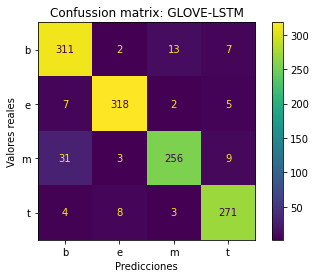

Epoch 1/4
743/743 [==============================] - 356s 473ms/step - loss: 0.4857 - accuracy: 0.8221
Epoch 2/4
743/743 [==============================] - 352s 474ms/step - loss: 0.2782 - accuracy: 0.9032
Epoch 3/4
743/743 [==============================] - 353s 475ms/step - loss: 0.1833 - accuracy: 0.9350
Epoch 4/4
40/40 [==============================] - 5s 105ms/step
************* METRICS AVERAGE: GLOVE-GRU *************
Accuracy:  93.52000000000001
Precision:  93.53363048033032
Recall:  93.45887447353684
f1:  93.49083850937139

************* METRICS BY CATEGORY GLOVE-GRU *************
Precision by cat.:  [91.29129129 96.08433735 91.30434783 95.45454545]
Recall by cat.:  [92.96636086 96.08433735 91.61073826 93.17406143]
f1 by cat.:  [92.12121212 96.08433735 91.45728643 94.30051813]



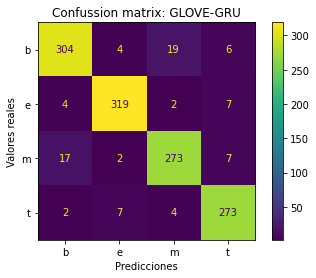

In [ ]:
for model in models:
  models[model].fit(train_data_pad, train_label_pad, epochs=epochs, batch_size=batch_size)
  label_prediction = models[model].predict(test_data_pad)
  label_pred = np.argmax(label_prediction, axis=1)
  my_evaluation(test_label_pad, label_pred, model)
  my_confusion_matrix(test_label_pad, label_pred, model)

In [ ]:
label_prediction = model.predict(test_data_pad)
label_pred = np.argmax(label_prediction, axis=1)

40/40 [==============================] - 5s 92ms/step


************* METRICS AVERAGE: GRU *************
Accuracy:  89.03999999999999
Precision:  89.02925000685609
Recall:  88.95538595630484
f1:  88.98807216291007

************* METRICS BY CATEGORY GRU *************
Precision by cat.:  [86.48648649 93.07228916 84.94983278 91.60839161]
Recall by cat.:  [88.0733945  93.07228916 84.94983278 89.7260274 ]
f1 by cat.:  [87.27272727 93.07228916 84.94983278 90.65743945]



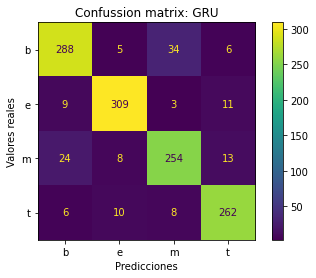

In [ ]:
my_evaluation(test_label_pad, label_pred, "WORD2VEC-LSTM")
my_confusion_matrix(test_label_pad, label_pred, "WORD2VEC-LSTM")